In [29]:
import urllib.request
import json
import geopandas as gpd
import pandas as pd

df = pd.read_csv('test2.csv')

def API_Request(Stations, SubscriptionKey):
    # API Headers
    url = f"https://gateway.apiportal.ns.nl/Spoorkaart-API/api/v1/traject.geojson?stations={Stations}"
    headers = {
        'Cache-Control': 'no-cache',
        'Ocp-Apim-Subscription-Key': SubscriptionKey,
    }

    # Make the API request
    try:
        req = urllib.request.Request(url, headers=headers)
        response = urllib.request.urlopen(req)
        response_content = response.read().decode('utf-8')

        # Load the response content into JSON
        geojson_data = json.loads(response_content)

        # Convert the GeoJSON data to a GeoDataFrame
        gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

        return gdf
    except urllib.error.HTTPError as e:
        print(f"HTTPError: {e.code} - {e.reason}")
        return None
    except Exception as e:
        print(f"Error: {e}")
        return None

# Loop through the DataFrame and make API requests
geometry_data = []

for i in range(len(df)):
    while True:
        try:
            # Make the API request
            geodata = API_Request(f'{df["From"][i]},{df["To"][i]}', SubscriptionKey)
            
            # If the API request is successful, add geometry data and break out of the loop
            if geodata is not None:
                geometry_data.append(geodata['geometry'].iloc[0])
                print(i)
                break
            else:
                # If the API fails, prompt for a new subscription key
                SubscriptionKey = input('Invalid SubscriptionKey. Please enter a new SubscriptionKey: ')
        except Exception as e:
            print(f"An error occurred: {e}")
            SubscriptionKey = input('Error occurred. Please enter a new SubscriptionKey: ')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [48]:
df = pd.read_csv('test2.csv')
df['geometry'] = geometry_data
df = gpd.GeoDataFrame(df, geometry='geometry')

df.to_csv('Geodata.csv')

In [31]:
count = 0
for i in range(len(df)):
    if df.loc[i, 'geometry'] == None:
        count += 1
        print(i)
print(count)

0


<Axes: >

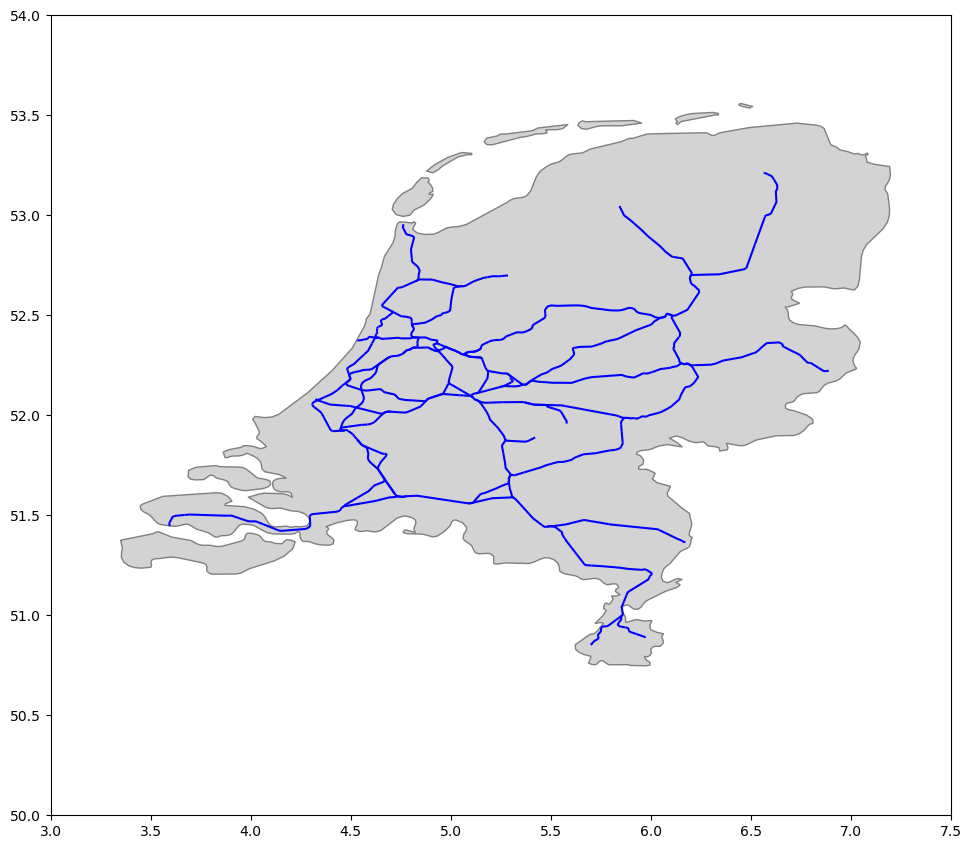

In [32]:
import matplotlib.pyplot as plt

#Nederland plotten
netherlands_shapefile_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
world = gpd.read_file(netherlands_shapefile_path)
netherlands = world[world['NAME'] == "Netherlands"]
fig = plt.figure(figsize=[12,8])
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim([3,7.5])
ax.set_ylim([50,54])
netherlands.plot(ax=ax,  color='lightgray', edgecolor = 'gray')

df.plot(ax=ax, color = 'blue')

In [33]:
import folium
import geopandas as gpd

# Function to plot GeoDataFrame interactively using Folium
def plot_folium(gdf):
    # Step 1: Create a base Folium map
    # Initialize the map centered on the mean of the coordinates
    m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=8)

    # Step 2: Add each geometry (LineString or Polygon) to the map
    folium.GeoJson(gdf).add_to(m)

    # Step 3: Return the map for interactive display
    return m

# Example: Plotting the previously created GeoDataFrame (gdf_routes)
map_interactive = plot_folium(df.set_crs(epsg=4326))

# Step 4: Display the map (if running in a notebook environment, this will display the map)
map_interactive

C:\Users\thijs\AppData\Local\Temp\ipykernel_17752\3980159523.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=8)


In [40]:
# function to assign a color to a number based on where in the range of numbers it lies
def interpolate_color(lower_limit, upper_limit, lower_color, upper_color, number):
    # Clamp the number between the lower and upper limit
    number = max(min(number, upper_limit), lower_limit)
    
    # Calculate the interpolation factor
    factor = (number - lower_limit) / (upper_limit - lower_limit)
    
    # Interpolate each RGB component
    interpolated_color = tuple(
        int(lower_component + (upper_component - lower_component) * factor)
        for lower_component, upper_component in zip(lower_color, upper_color)
    )
    
    #normalize the color for usage
    color = [interpolated_color / 255.0 for interpolated_color in interpolated_color] 

    return str(color)

In [49]:
df = df.sort_values(by='Seats', ascending=True).reset_index()
df.to_csv('test2_sorted.csv')
display(df)
df['color'] = 0
for i in range(len(df)):
    print(interpolate_color(df['Seats'].min(), 1359216.0, (0,0,255), (255,0,0), df.loc[i, 'Seats']))
    print(type(interpolate_color(df['Seats'].min(), 1359216.0, (0,0,255), (255,0,0), df.loc[i, 'Seats'])))
    df.loc[i, 'color'] = interpolate_color(df['Seats'].min(), 1359216.0, (0,0,255), (255,0,0), df.loc[i, 'Seats'])
display(df)
df.to_csv('test2_sorted.csv')

,index,Unnamed: 0,From,To,Seats,geometry
0,279,279,Asa,Asdmm,54340.0,LINESTRING EMPTY
1,280,280,Asdmm,Asd,54340.0,LINESTRING EMPTY
2,267,267,Brn,Sd,54746.0,"LINESTRING (5.28084 52.20834, 5.28201 52.20797..."
3,268,268,Sd,St,54746.0,"LINESTRING (5.3 52.18361, 5.30008 52.18325, 5...."
4,270,270,Stz,Dld,54746.0,"LINESTRING (5.30299 52.16531, 5.2998 52.16328,..."
...,...,...,...,...,...,...
280,90,90,Ashd,Asb,1790196.0,"LINESTRING (4.95974 52.29844, 4.95081 52.30819..."
281,89,89,Ac,Ashd,1790196.0,"LINESTRING (4.97693 52.27847, 4.97655 52.27893..."
282,88,88,Bkl,Ac,1790196.0,"LINESTRING (4.99065 52.17148, 4.99066 52.1721,..."
283,84,84,Utvr,Ut,2019636.0,"LINESTRING (5.12174 52.07897, 5.12099 52.07924..."


[0.0, 0.0, 1.0]
<class 'str'>
[0.0, 0.0, 1.0]
<class 'str'>
[0.0, 0.0, 0.996078431372549]
<class 'str'>
[0.0, 0.0, 0.996078431372549]
<class 'str'>
[0.0, 0.0, 0.996078431372549]
<class 'str'>
[0.0, 0.0, 0.996078431372549]
<class 'str'>
[0.0196078431372549, 0.0, 0.9764705882352941]
<class 'str'>
[0.0196078431372549, 0.0, 0.9764705882352941]
<class 'str'>
[0.03137254901960784, 0.0, 0.9647058823529412]
<class 'str'>
[0.03137254901960784, 0.0, 0.9647058823529412]
<class 'str'>
[0.03137254901960784, 0.0, 0.9647058823529412]
<class 'str'>
[0.03137254901960784, 0.0, 0.9647058823529412]
<class 'str'>
[0.043137254901960784, 0.0, 0.9529411764705882]
<class 'str'>
[0.058823529411764705, 0.0, 0.9372549019607843]
<class 'str'>
[0.06274509803921569, 0.0, 0.9333333333333333]
<class 'str'>
[0.06666666666666667, 0.0, 0.9294117647058824]
<class 'str'>
[0.06666666666666667, 0.0, 0.9294117647058824]
<class 'str'>
[0.06666666666666667, 0.0, 0.9294117647058824]
<class 'str'>
[0.06666666666666667, 0.0, 0.929

C:\Users\thijs\AppData\Local\Temp\ipykernel_17752\3710882617.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0, 0.0, 1.0]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'color'] = interpolate_color(df['Seats'].min(), 1359216.0, (0,0,255), (255,0,0), df.loc[i, 'Seats'])


,index,Unnamed: 0,From,To,Seats,geometry,color
0,279,279,Asa,Asdmm,54340.0,LINESTRING EMPTY,"[0.0, 0.0, 1.0]"
1,280,280,Asdmm,Asd,54340.0,LINESTRING EMPTY,"[0.0, 0.0, 1.0]"
2,267,267,Brn,Sd,54746.0,"LINESTRING (5.28084 52.20834, 5.28201 52.20797...","[0.0, 0.0, 0.996078431372549]"
3,268,268,Sd,St,54746.0,"LINESTRING (5.3 52.18361, 5.30008 52.18325, 5....","[0.0, 0.0, 0.996078431372549]"
4,270,270,Stz,Dld,54746.0,"LINESTRING (5.30299 52.16531, 5.2998 52.16328,...","[0.0, 0.0, 0.996078431372549]"
...,...,...,...,...,...,...,...
280,90,90,Ashd,Asb,1790196.0,"LINESTRING (4.95974 52.29844, 4.95081 52.30819...","[1.0, 0.0, 0.0]"
281,89,89,Ac,Ashd,1790196.0,"LINESTRING (4.97693 52.27847, 4.97655 52.27893...","[1.0, 0.0, 0.0]"
282,88,88,Bkl,Ac,1790196.0,"LINESTRING (4.99065 52.17148, 4.99066 52.1721,...","[1.0, 0.0, 0.0]"
283,84,84,Utvr,Ut,2019636.0,"LINESTRING (5.12174 52.07897, 5.12099 52.07924...","[1.0, 0.0, 0.0]"


In [36]:
import pandas as pd

# Assuming 'df' is already defined and 'Seats' column exists

# Initialize the 'color' column with empty lists or None
df['color'] = None

# Loop through the DataFrame to assign colors
for i in range(len(df)):
    # Compute the interpolated color and store it in the DataFrame
    df.loc[i, 'color'] = interpolate_color(
        df['Seats'].min(),
        df['Seats'].max(),
        (0, 0, 255),  # RGB color for blue
        (255, 0, 0),  # RGB color for red
        df.loc[i, 'Seats']  # Current seat value
    )

# Display the updated DataFrame
df = df.sort_values(by='Seats', ascending=True).reset_index()
display(df)


,index,Unnamed: 0,From,To,Seats,geometry,color
0,279,279,Asa,Asdmm,54340.0,LINESTRING EMPTY,"[0.0, 0.0, 1.0]"
1,280,280,Asdmm,Asd,54340.0,LINESTRING EMPTY,"[0.0, 0.0, 1.0]"
2,267,267,Brn,Sd,54746.0,"LINESTRING (5.28084 52.20834, 5.28201 52.20797...","[0.0, 0.0, 0.996078431372549]"
3,268,268,Sd,St,54746.0,"LINESTRING (5.3 52.18361, 5.30008 52.18325, 5....","[0.0, 0.0, 0.996078431372549]"
4,270,270,Stz,Dld,54746.0,"LINESTRING (5.30299 52.16531, 5.2998 52.16328,...","[0.0, 0.0, 0.996078431372549]"
...,...,...,...,...,...,...,...
280,90,90,Ashd,Asb,1790196.0,"LINESTRING (4.95974 52.29844, 4.95081 52.30819...","[0.6, 0.0, 0.396078431372549]"
281,89,89,Ac,Ashd,1790196.0,"LINESTRING (4.97693 52.27847, 4.97655 52.27893...","[0.6, 0.0, 0.396078431372549]"
282,88,88,Bkl,Ac,1790196.0,"LINESTRING (4.99065 52.17148, 4.99066 52.1721,...","[0.6, 0.0, 0.396078431372549]"
283,84,84,Utvr,Ut,2019636.0,"LINESTRING (5.12174 52.07897, 5.12099 52.07924...","[0.6823529411764706, 0.0, 0.3137254901960784]"


c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


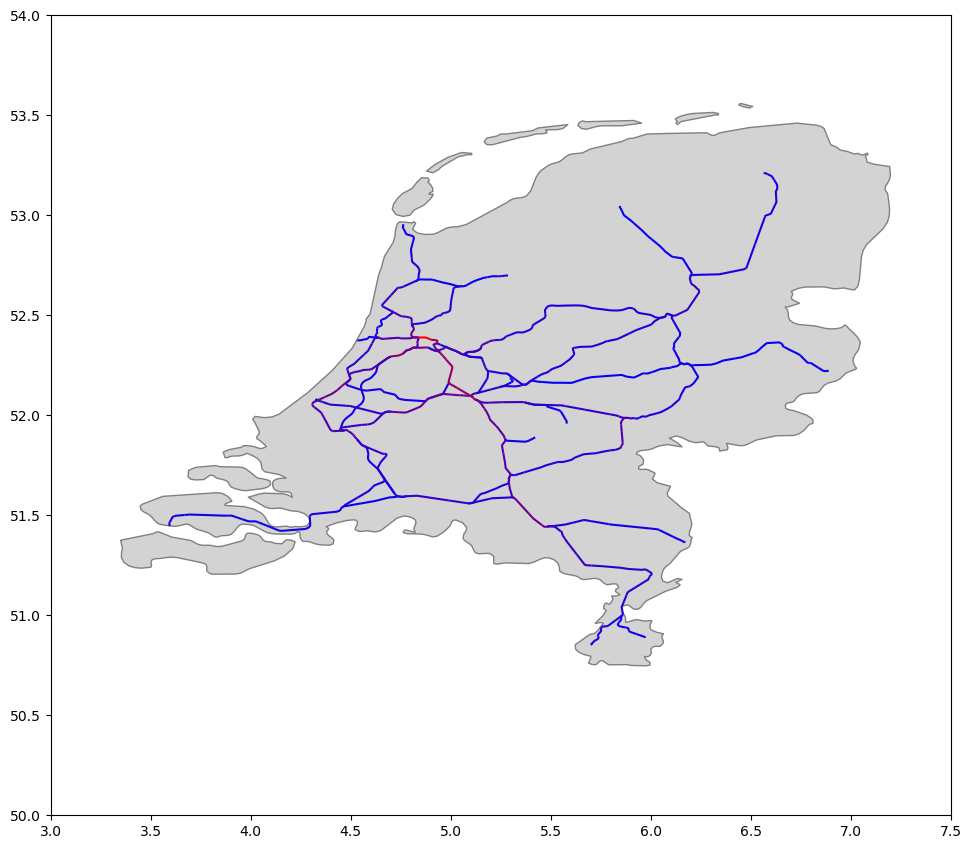

In [37]:
import matplotlib.pyplot as plt
import ast

#Nederland plotten
netherlands_shapefile_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
world = gpd.read_file(netherlands_shapefile_path)
netherlands = world[world['NAME'] == "Netherlands"]
fig = plt.figure(figsize=[12,8])
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim([3,7.5])
ax.set_ylim([50,54])
ax.set_aspect('equal', adjustable='box')
netherlands.plot(ax=ax,  color='lightgray', edgecolor = 'gray')

for i in range(len(df)):
    df.iloc[[i]].plot(ax=ax, color = ast.literal_eval((df.loc[i, 'color'])))


c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)
c:\Users\thijs\anaconda3\envs\TIL6022\Lib\site-packages\geopandas\plotting.py:968: UserWarning: The GeoSeries you are attempting to plot is composed of empty geometries. Nothing has been displayed.
  return plot_dataframe(data, *args, **kwargs)


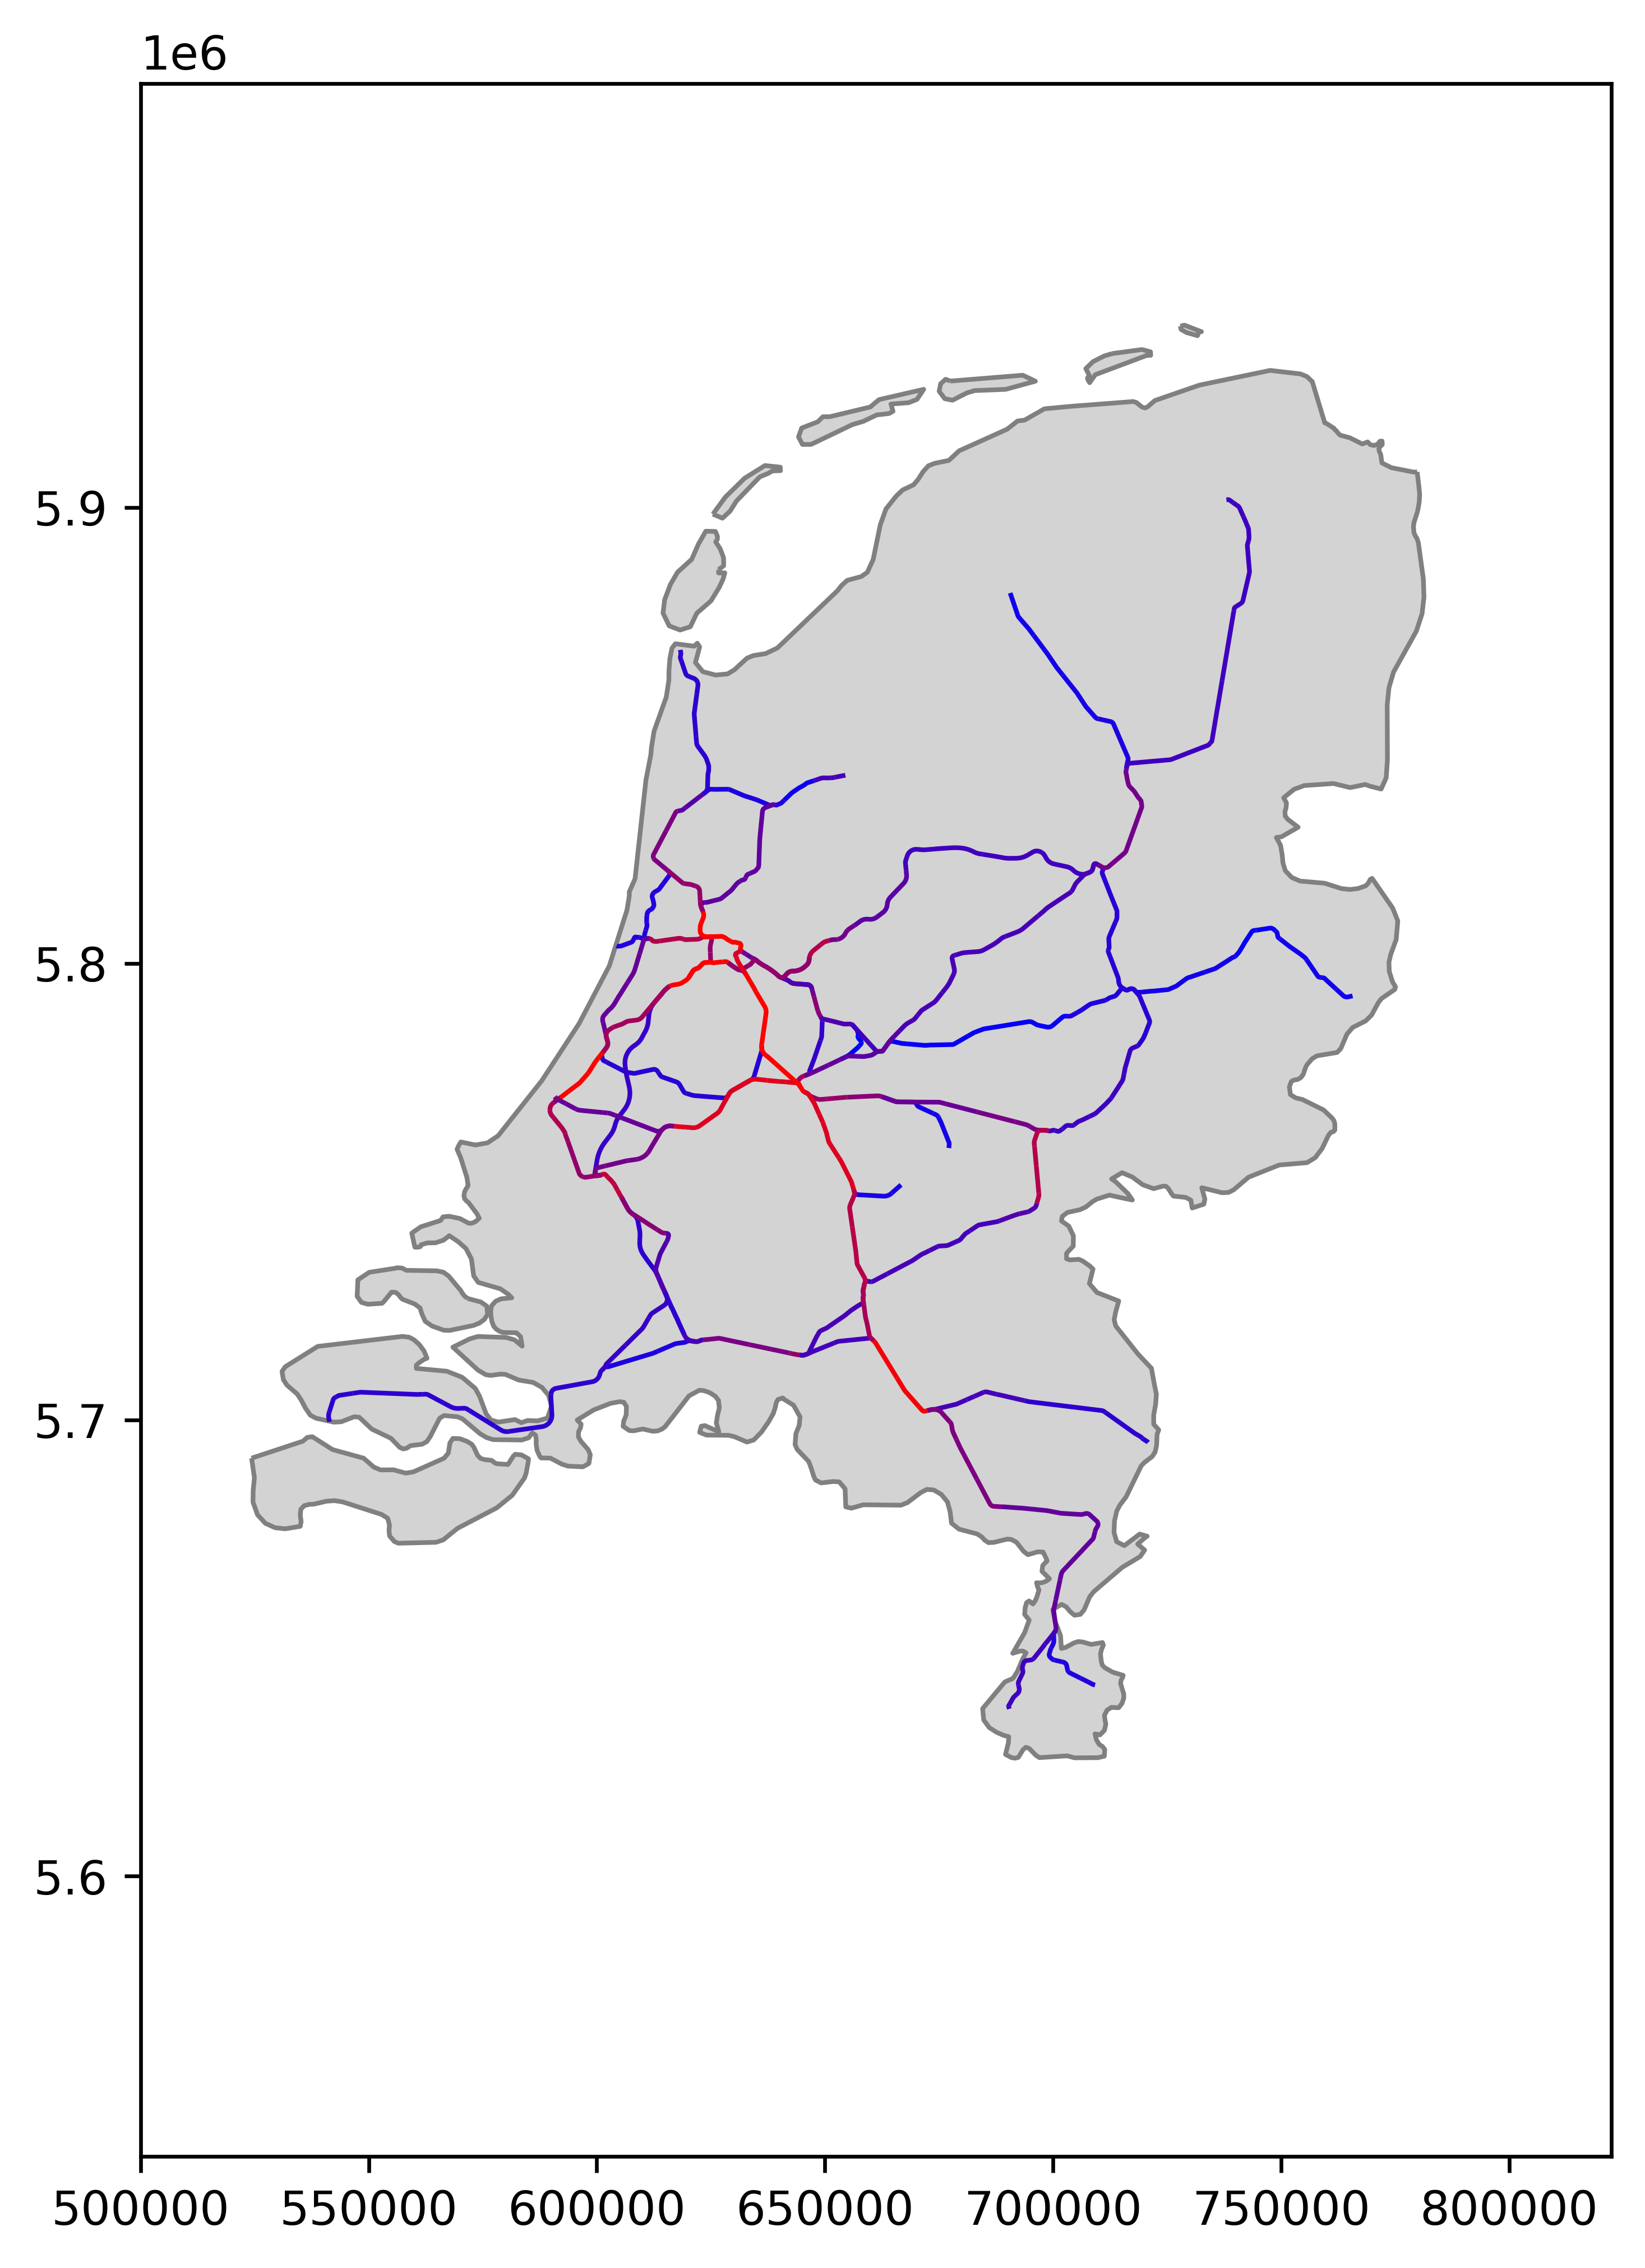

In [50]:
import matplotlib.pyplot as plt
import ast
import geopandas as gpd
from shapely.geometry import box

# Load the shapefile of the Netherlands
netherlands_shapefile_path = "ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp"
world = gpd.read_file(netherlands_shapefile_path)
netherlands = world[world['NAME'] == "Netherlands"]

# Set the CRS for the Netherlands shapefile to WGS84 (assuming it uses lat/lon)
netherlands = netherlands.set_crs(epsg=4326)

# Reproject the Netherlands shapefile to UTM (Zone 31N for the Netherlands)
netherlands = netherlands.to_crs(epsg=32631)

# Set the CRS for the dataframe `df` (assuming df contains lat/lon coordinates)
if df.crs is None:
    df = df.set_crs(epsg=4326)  # Set to WGS84 if no CRS is defined

# Reproject `df` to the same UTM projection (EPSG:32631)
df = df.to_crs(epsg=32631)

# Define original limits in WGS84 (lat/lon)
lon_min, lon_max = 3, 7.5
lat_min, lat_max = 50, 54

# Create a GeoDataFrame to represent the bounding box
bbox = gpd.GeoDataFrame(
    {'geometry': [box(lon_min, lat_min, lon_max, lat_max)]}, 
    crs="EPSG:4326"
)

# Reproject the bounding box to UTM (to match the Netherlands and df projection)
bbox = bbox.to_crs(epsg=32631)

# Extract the limits from the reprojected bounding box
minx, miny, maxx, maxy = bbox.total_bounds

# Create figure
fig, ax = plt.subplots(figsize=[12, 8], dpi=600)

# Set the new limits using the reprojected UTM coordinates
ax.set_xlim([minx, maxx])
ax.set_ylim([miny, maxy])

# Plot the reprojected Netherlands
netherlands.plot(ax=ax, color='lightgray', edgecolor='gray')

# Plot your data points with associated colors
for i in range(len(df)):
    df.iloc[[i]].plot(ax=ax, color=ast.literal_eval(df.loc[i, 'color']), linewidth=1)

plt.show()
